# Import

In [1]:
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
import importlib
import efrc_ml_production as ml
importlib.reload(ml)

<module 'efrc_ml_production' from '/home/rgur/py_scripts/efrc_ml_production.py'>

In [5]:
from sklearn.metrics import r2_score as r2

In [6]:
import os
from os import listdir
from os.path import isfile, join

In [7]:
import rishi_utils as ru
importlib.reload(ru)

<module 'rishi_utils' from '/home/rgur/py_scripts/rishi_utils.py'>

In [8]:
os.getcwd()

'/home/rgur/py_scripts'

# Define variables

In [9]:
results_dir = ru.sanitize_dir_path('/data/rgur/efrc/paper_data/benchmark/test_space')

In [10]:
stacked_path = '/data/rgur/efrc/prep_data/all_v1/stacked.csv'
ml_d_path = '/data/rgur/efrc/prep_data/all_v1/ml_data.csv'

In [11]:
Y_DATA_PATH = '/data/rgur/efrc/data_DONOTTOUCH/hMOF_allData_March25_2013.xlsx'

In [12]:
stacked = ru.pd_load('/data/rgur/efrc/prep_data/all_v1/stacked.csv')
ml_d = ru.pd_load('/data/rgur/efrc/prep_data/all_v1/ml_data.csv')

/home/rgur/.conda/envs/efrc/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/rgur/.conda/envs/efrc/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [13]:
ml_d = ml.merge_data(ml_d, False, Y_DATA_PATH)

In [14]:
stacked_map = {}
for i in stacked[['filename', 'pressure','vol_uptake']].iterrows():
    val = i[1]
    stacked_map[(val['filename'], val['pressure'])] = val['vol_uptake']

In [15]:
grav_map = {}
for i in ml_d[['filename', 'CH4_cm3/g_35_bar']].iterrows():
    val = i[1]
    grav_map[val['filename']] = val['CH4_cm3/g_35_bar']

# Define functions

In [16]:
def getMetrics(true, pred, metrics):
    '''
    Get metric values from a list if metric functions
    '''
    return [f(true, pred) for f in metrics]

In [17]:
def checkIsoFile(filename):
    '''
    Determine whether or not filename should be included
    '''
    if filename[-4:] == '.csv':
        if 'iso' in filename:
            row_count = ru.count_lines(filename) - 1
            if row_count == 533430:
                return True
    return False

In [18]:
def checkGravFile(filename):
    '''
    Determine whether or not filename should be included
    '''
    if filename[-4:] == '.csv':
        if 'grav' in filename:
            row_count = ru.count_lines(filename) - 1
            if row_count == 126369:
                return True
    return False

In [19]:
def get_t_pct(filename):
    return float(filename.split('train_')[1][:2])

In [20]:
def get_Code(filename):
    return filename.split('code_')[1][:4]

In [21]:
def getSeed(filename):
    return filename.split('seed_')[1][:1]

In [22]:
def getAllFilenames(parent_dir):
    return [parent_dir+f for f in listdir(parent_dir) if isfile(join(parent_dir, f))]

In [23]:
def getTruthVals(train_keys, test_keys, my_map):
    train_truth = [my_map[f] for f in train_keys]
    test_truth = [my_map[f] for f in test_keys]
    return train_truth, test_truth

In [24]:
def getPredsAndKeys(df):
    n_unique_pressures = len(df['Pressure'].unique())
    train_df = df[df['Class'] == 'Train']
    test_df = df[df['Class'] == 'Test']
    train_preds = train_df['Prediction'].tolist()
    test_preds = test_df['Prediction'].tolist()
    if n_unique_pressures == 1:
        train_keys = train_df['Filename'].tolist()
        test_keys = test_df['Filename'].tolist()
    else:
        train_keys = [tuple(r) for r in train_df[['Filename', 'Pressure']].to_numpy()]
        test_keys = [tuple(r) for r in test_df[['Filename', 'Pressure']].to_numpy()]
    return train_preds, train_keys, test_preds, test_keys

In [25]:
def get_time(f):
    return '_'.join(f.split('.')[0].split('_')[-6:])

In [26]:
def unflatten(l, n):
    new = []
    length = len(l)
    prev = 0
    split_inds = list(range(0, length+1, n))
    prev = 0
    for ind in split_inds[1:]:
        new.append(l[prev:ind])
        prev = ind
    return new

In [27]:
def getMetricsFromDf(f, fix_preds, stacked):
    #df = pd.read_csv(f)
    df = ru.pd_load(f)
    if fix_preds:
        fix_predictions(df)
    train_preds, train_keys, test_preds, test_keys = getPredsAndKeys(df)
    if stacked:
        my_map = stacked_map
    else:
        my_map = grav_map
    train_truth, test_truth = getTruthVals(train_keys, test_keys, my_map)
    train_vals = getMetrics(true=train_truth, pred=train_preds, metrics=[ml.get_rmse, r2, ru.avg_max_n_pct_error])
    test_vals = getMetrics(true=test_truth, pred=test_preds, metrics=[ml.get_rmse, r2, ru.avg_max_n_pct_error])
    return (train_vals, test_vals)

In [28]:
def getResultsDf(good_codes=None, good_time=None, fix_preds=True, include_geo=False, stacked=False, n_seed=3):
    
    for i in range(n_seed):
        run_num = i+1
        exec('run%s_r2s,run%s_rmses,run%s_am1pes = [],[],[]' %( run_num,run_num,run_num ))
    
    train_pcts = []
    codes = []
    classes = []
    all_files = getAllFilenames(results_dir)
    if stacked:
        checkFile = checkIsoFile
    else:
        checkFile = checkGravFile
    relevent = [f for f in all_files if checkFile(f)]
    #print(relevent[0:5])
    unique_codes = list(set([get_Code(f) for f in relevent]))
    if include_geo==True:
        print('Only including geometric codes')
        good_codes = [code for code in unique_codes if code[-1] == '1']
    elif include_geo==False:
        print('Only including non-geometric codes')
        good_codes = [code for code in unique_codes if code[-1] == '0']
    if good_codes != None:
        relevent = [f for f in relevent if get_Code(f) in good_codes]
    #print(relevent[0:5])
    if good_time != None:
        relevent = [f for f in relevent if get_time(f) in good_time]
    #print(relevent[0:5])
    relevent = sorted(relevent)
    #print(relevent[0:5])
    unique_codes = list(set([get_Code(f) for f in relevent]))
    print(unique_codes)
    
    nested_relevent = unflatten(relevent, n_seed)
    for l in nested_relevent:
        f = l[0]
        codes += [get_Code(f)]*2
        classes.append("Train")
        classes.append("Test")
        train_pcts += [get_t_pct(f)]*2
        vals = [getMetricsFromDf(f, fix_preds, stacked) for f in l] #[seed 0, seed 1, seed 2], [train, test], [rmse, r2, am1pe]

        for i in range(n_seed):
            run_num = i+1
            exec('run%s_r2s.append(vals[%s][0][1])' %( run_num,i ))
            exec('run%s_r2s.append(vals[%s][1][1])' %( run_num,i ))

            exec('run%s_rmses.append(vals[%s][0][0])' %( run_num,i ))
            exec('run%s_rmses.append(vals[%s][1][0])' %( run_num,i ))
            
            exec('run%s_am1pes.append(vals[%s][0][2])' %( run_num,i ))
            exec('run%s_am1pes.append(vals[%s][1][2])' %( run_num,i ))            
            
    df = pd.DataFrame({"Training %": train_pcts, "Code": codes, "Class": classes})
    for i in range(n_seed):
        run_num = i+1
        exec("df['Run %s R2'] = run%s_r2s" %(run_num,run_num))
        exec("df['Run %s RMSE'] = run%s_rmses" %(run_num,run_num))
        exec("df['Run %s AM1PE'] = run%s_am1pes" %(run_num,run_num))
    return df

In [29]:
def labelFromCode(code):
    s = ''
    if code[0] == '1':
        s+='SI+'
    if code[1] == '1':
        s+='SD+'
    if code[2] == '1':
        s+='LS+'
    if code[3] == '1':
        s+='Geo+'
    return s[:-1]

In [30]:
def fix_predictions(df):
    preds = df['Prediction'].tolist()
    new = []
    for i in preds:
        if i<0:
            new.append(0)
        else:
            new.append(i)
    df['Prediction'] = new

In [31]:
def plot_results(df, title='Learning Curve', good_codes=None, score_name='RMSE', ylim=None, axes=None, 
                 place_legend='in', custom_labels=None, custom_colors=None):
    colors = ['r', 'k', 'b', 'c', 'm', 'y', 'darkorange', 'slategray', 'tan', 'deeppink', 'greenyellow','g']
    n_plots = len
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(8, 8))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Percent of Data Set Used For Training")
    axes.set_ylabel(score_name)
    if good_codes == None:
        good_codes = df['Code'].unique().tolist()
    if custom_colors==None:
        color_map = {}
        for ind, code in enumerate(good_codes):
            color_map[code] = colors[ind]
    else:
        color_map = custom_colors
    for ind, code in enumerate(good_codes):
        if custom_labels == None:
            LABEL = labelFromCode(code)
            TRAIN_LABEL = "Training %s - %s" %(score_name, LABEL)
            TEST_LABEL = "Test %s - %s" %(score_name, LABEL)
        else:
            TRAIN_LABEL, TEST_LABEL = custom_labels[code]
        df_code = df[df['Code'] == code]
        train_df = df_code[df_code['Class'] == 'Train']
        test_df = df_code[df_code['Class'] == 'Test']
        score_train_df = train_df[['Run 1 %s' %score_name, 'Run 2 %s' %score_name, 'Run 3 %s' %score_name]]
        score_test_df = test_df[['Run 1 %s' %score_name, 'Run 2 %s' %score_name, 'Run 3 %s' %score_name]]
        train_sizes = df['Training %'].unique()

        train_scores_mean = np.mean(score_train_df, axis=1)
        train_scores_std = np.std(score_train_df, axis=1)
        test_scores_mean = np.mean(score_test_df, axis=1)
        test_scores_std = np.std(score_test_df, axis=1)
        #fit_times_mean = np.mean(fit_times, axis=1)
        #fit_times_std = np.std(fit_times, axis=1)

        train_scores_mean = train_scores_mean
        train_scores_std = train_scores_std
        test_scores_mean = test_scores_mean
        test_scores_std = test_scores_std
        
        # Plot learning curve
        n_done = len(train_scores_mean) #in case not all runs are done yet
        axes.grid()
        axes.fill_between(train_sizes[0:n_done], train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1,
                             color=color_map[code])
        axes.fill_between(train_sizes[0:n_done], test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1,
                             color=color_map[code])
        axes.plot(train_sizes[0:n_done], train_scores_mean, 'o-', color=color_map[code],
                     label=TRAIN_LABEL)
        axes.plot(train_sizes[0:n_done], test_scores_mean, 'x-', color=color_map[code],
                     label=TEST_LABEL)
    if place_legend == 'out':
        axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        axes.legend(loc="best")

    return plt

# Run 

In [32]:
results_dir = ru.sanitize_dir_path('/data/rgur/efrc/paper_data/benchmark/si_ls_geo')
GOOD_CODES = ['1011', '1010']
#GOOD_TIME = ['08_37PM_on_April_18_2020', '02_56PM_on_April_20_2020']
#GOOD_TIME = ['08_37PM_on_April_18_2020']
#GOOD_TIME = ['05_52PM_on_April_26_2020', '11_15AM_on_April_28_2020', '05_14PM_on_April_28_2020']
#GOOD_TIME = ['12_18PM_on_April_29_2020', '12_01PM_on_April_30_2020', '06_24PM_on_May_03_2020']
#GOOD_TIME = ['11_31AM_on_May_05_2020']
GOOD_TIME = ['02_45PM_on_May_07_2020']

results_df = getResultsDf(good_codes=None, good_time=GOOD_TIME, fix_preds=True, include_geo=True, 
                           stacked=False, n_seed=5)

Only including geometric codes
['1011']


In [33]:
results_df.to_csv('%s%s.csv' %( results_dir,ru.add_timestamp('results_df_') ))

In [36]:
df=ru.pd_load('/data/rgur/efrc/paper_data/benchmark/si_ls_geo/results_grav_code_1011_train_70_seed_20_02_45PM_on_May_07_2020.csv')

In [37]:
df.head()

,Filename,Pressure,Class,Prediction
0,hypotheticalMOF_6000523_i_3_j_19_k_12_m_9_cat_...,35,Train,-3.266846
1,hypotheticalMOF_5051526_i_1_j_27_k_5_m_9_cat_1...,35,Train,256.560883
2,hypotheticalMOF_5004666_i_0_j_20_k_12_m_1_cat_...,35,Train,97.155838
3,hypotheticalMOF_5032463_i_0_j_29_k_21_m_4_cat_...,35,Train,360.232239
4,hypotheticalMOF_30888_i_2_j_9_k_6_m_0_cat_1.cif,35,Train,163.459396


In [39]:
len(df[df['Class']=='Test'])

37911

In [33]:
test = results_df[(results_df['Class']=='Test') & (results_df['Training %']==70.0)]
#test = results_df[results_df['Class']=='Test']

In [34]:
test

,Training %,Code,Class,Run 1 R2,Run 1 RMSE,Run 1 AM1PE,Run 2 R2,Run 2 RMSE,Run 2 AM1PE,Run 3 R2,Run 3 RMSE,Run 3 AM1PE,Run 4 R2,Run 4 RMSE,Run 4 AM1PE,Run 5 R2,Run 5 RMSE,Run 5 AM1PE
1,70.0,1011,Test,0.992419,9.121642,33.301128,0.991905,9.438606,36.395426,0.992515,9.049648,33.538797,0.992105,9.288681,34.645406,0.992022,9.378253,35.506429


In [66]:
np.min(test[['Run 1 RMSE', 'Run 2 RMSE', 'Run 3 RMSE', 'Run 4 RMSE', 'Run 5 RMSE']].to_numpy())

9.04964766041376

In [38]:
np.argmin(test[['Run 1 RMSE', 'Run 2 RMSE', 'Run 3 RMSE', 'Run 4 RMSE', 'Run 5 RMSE']].to_numpy())

2

In [36]:
n_seed = 5
for i in ['R2', 'RMSE', 'AM1PE']:
    results_df['Average %s' %i] = np.mean(results_df[['Run %s %s'%(j+1,i) for j in range(n_seed)]], axis=1)
    results_df['Std %s' %i] = np.std(results_df[['Run %s %s'%(j+1,i) for j in range(n_seed)]], axis=1)

In [37]:
results_df

,Training %,Code,Class,Run 1 R2,Run 1 RMSE,Run 1 AM1PE,Run 2 R2,Run 2 RMSE,Run 2 AM1PE,Run 3 R2,...,Run 4 AM1PE,Run 5 R2,Run 5 RMSE,Run 5 AM1PE,Average R2,Std R2,Average RMSE,Std RMSE,Average AM1PE,Std AM1PE
0,70.0,1011,Train,0.994422,7.826133,28.269893,0.994173,7.994779,29.468789,0.995027,...,25.642384,0.994950,7.439695,28.731370,0.994724,0.000358,7.607857,0.253456,27.850844,1.337815
1,70.0,1011,Test,0.992419,9.121642,33.301128,0.991905,9.438606,36.395426,0.992515,...,34.645406,0.992022,9.378253,35.506429,0.992193,0.000234,9.255366,0.148317,34.677437,1.168800


# Parity Plot

In [51]:
preds = ru.pd_load('/data/rgur/efrc/paper_data/benchmark/si_ls_geo/results_grav_code_1011_train_70_seed_20_02_45PM_on_May_07_2020.csv')

In [52]:
fix_preds = preds['Prediction']

In [53]:
fix_preds = [max(0,x) for x in fix_preds]

In [54]:
truth = []
for i in preds[['Filename', 'Pressure']].iterrows():
    val = i[1]
    truth.append( grav_map[(val['Filename'])] )

In [55]:
test_start = preds[preds['Class'] == 'Test'].index.to_list()[0]

In [56]:
res_test_label = truth[test_start:]
res_test_predictions = fix_preds[test_start:]
res_train_label = truth[:test_start]
res_train_predictions = fix_preds[:test_start]

In [57]:
res_train_label[0:5]

[3.94834830479539e-11,
 255.463092283871,
 95.0219380750658,
 364.182646495157,
 171.069970112679]

In [58]:
res_train_predictions[0:5]

[0,
 256.56088256835943,
 97.15583801269531,
 360.23223876953125,
 163.4593963623047]

In [59]:
def fix_na(true, pred):
    df = pd.DataFrame({'True': true, 'Pred': pred}).dropna()
    return df['True'].to_list(), df['Pred'].to_list()

In [60]:
res_test_label, res_test_predictions = fix_na(res_test_label, res_test_predictions)

In [61]:
res_train_label, res_train_predictions = fix_na(res_train_label, res_train_predictions)

Test RMSE is 9.04964766041376


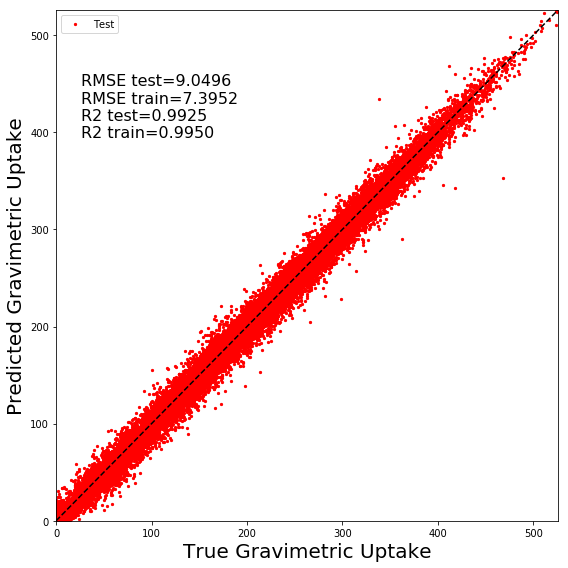

In [73]:
fig1,ax1 = plt.subplots(figsize = (8,8))


rmse = ml.get_rmse(res_test_label, res_test_predictions)
print("Test RMSE is %s" %rmse)

tr_rmse = ml.get_rmse(res_train_label, res_train_predictions)

from sklearn.metrics import r2_score as r2

r2_val = r2(y_true=res_test_label, y_pred=res_test_predictions)
r2_tr = r2(y_true=res_train_label, y_pred=res_train_predictions)

ax1.scatter(res_test_label, res_test_predictions, marker='o', c='r',s=5, label='Test')
is_stacked = False
if is_stacked:
    x_lab = 'True Volumetric Uptake'
    y_lab = 'Predicted Volumetric Uptake'
else:
    x_lab = 'True Gravimetric Uptake'
    y_lab = 'Predicted Gravimetric Uptake'

ax1.set_xlabel(x_lab,fontsize=20)
ax1.set_ylabel(y_lab,fontsize=20)
max_val = max([max(res_test_label),max(res_test_predictions)])+1
ax1.set_xlim(0, max_val)
ax1.set_ylim(0, max_val)

plot_x_min, plot_x_max = plt.xlim()
plot_y_min, plot_y_max = plt.ylim()
ax1.legend()
ax1.plot(np.linspace(plot_x_min,plot_x_max,100),np.linspace(plot_y_min,plot_y_max,100),c='k',ls='--')
text_position_x = plot_x_min + (plot_x_max - plot_x_min) * 0.05
text_position_y = plot_y_max - (plot_y_max - plot_y_min) * 0.25

ax1.text(text_position_x, text_position_y, "RMSE test=" + str("%.4f" % rmse) + '\n' + 
         "RMSE train=" + str("%.4f" % tr_rmse) + '\n' +
         "R2 test=" + str("%.4f" % r2_val) + '\n' +
         "R2 train=" + str("%.4f" % r2_tr), ha='left', fontsize=16)
fig1.tight_layout()

# Scratch

In [75]:
train_df = results_df[(results_df['Class'] == 'Test') & (results_df['Training %'] == 70.0)][['Run 1 RMSE', 
                                                        'Run 2 RMSE', 'Run 3 RMSE', 'Run 4 RMSE', 'Run 5 RMSE']]

In [76]:
train_df['Average RMSE'] = np.mean(train_df, axis=1)

In [77]:
train_df['STD RMSE'] = np.std(train_df, axis=1)

In [78]:
train_df

,Run 1 RMSE,Run 2 RMSE,Run 3 RMSE,Run 4 RMSE,Run 5 RMSE,Average RMSE,STD RMSE
1,9.328158,9.019841,9.326236,9.107331,9.38206,9.232726,0.129869


In [35]:
df = ru.pd_load('/data/rgur/efrc/ml/results/results_grav_code_0100_train_50_seed_0_12_01PM_on_April_30_2020.csv')

# Test functions

In [ ]:
getMetrics([1,0,0], [1,0,0], [ml.get_rmse, r2]) 

In [ ]:
a = '/data/rgur/efrc/ml/results/results_grav_code_1110_train_60_seed_0_12_34PM_on_April_17_2020.csv'

In [ ]:
checkGravFile(a)

In [ ]:
unflatten([0,1,2,3,4,6,7,8,9], 3)

In [ ]:
labelFromCode('1111')

In [91]:
df = ru.pd_load('/data/rgur/efrc/ml/results/results_grav_code_1000_train_50_seed_0_12_18PM_on_April_29_2020.csv')

In [92]:
df

,Unnamed: 0,Filename,Pressure,Class,Prediction
0,0,hypotheticalMOF_5053773_i_1_j_27_k_27_m_7_cat_...,35,Train,310.802795
1,1,hypotheticalMOF_5051526_i_1_j_27_k_5_m_9_cat_1...,35,Train,249.915619
2,2,hypotheticalMOF_5004666_i_0_j_20_k_12_m_1_cat_...,35,Train,89.942970
3,3,hypotheticalMOF_5024913_i_0_j_27_k_17_m_7_cat_...,35,Train,232.454697
4,4,hypotheticalMOF_15055_i_0_j_17_k_13_m_7_cat_1.cif,35,Train,175.953964
5,5,hypotheticalMOF_5022583_i_0_j_26_k_26_m_11_cat...,35,Train,235.852203
6,6,hypotheticalMOF_5065435_i_2_j_21_k_17_m_10_cat...,35,Train,112.377510
7,7,hypotheticalMOF_9033_i_0_j_13_k_2_m_10_cat_1.cif,35,Train,160.230682
8,8,hypotheticalMOF_5005681_i_0_j_20_k_19_m_7_cat_...,35,Train,67.108932
9,9,hypotheticalMOF_5046246_i_1_j_25_k_1_m_1_cat_1...,35,Train,192.713150
